# EQUILIBRANDO CLASSES

## IMPORTANDO BIBLIOTECAS

In [82]:
# Para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import kagglehub
import matplotlib.pyplot as plt

In [81]:
# Treinar modelos e pré-processamento
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Avaliar os modelos
from sklearn.metrics import (mean_absolute_error, 
                            mean_squared_error,
                            r2_score, roc_curve,
                            auc,classification_report,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            precision_recall_curve,
                            accuracy_score,
                            recall_score,
                            precision_score,
                            f1_score)
# Métodos de Balanceamentos
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Para o excel
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font, Border, Side, Alignment

In [61]:

#carregando o dataset através do kaggle
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

#conferindo o caminho salvo
print("Path to dataset files:", path)

Path to dataset files: /home/caique-s/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


## FUNÇÕES

In [62]:
def fix_width_cell(ws):
    # Vai reajustar as colunas do excel para o tamanho do maior elemento dele
    for coll in ws.columns:
        max_len = 0
        col_letter = coll[0].column_letter

        for cell in coll:
            cell.alignment = Alignment(horizontal="left")
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
            except:
                pass

        ws.column_dimensions[col_letter].width = max_len + 2  # margem extra


In [63]:
def save_sheet(method, y_test, prev, prec_recall, roc):
    # Salva os dados no excel
    wb = False;

    # tenta abrir o arquivo e, caso não exista, cria ele
    try:
        wb = load_workbook("resultados.xlsx")
        ws = wb.active
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "Resultados"

    # Métricas são calculados independentes
    accur = accuracy_score(y_test, prev)
    recall = recall_score(y_test, prev)
    prec = precision_score(y_test, prev)
    f1 = f1_score(y_test, prev)

    # Encontra a próxima linha vazia
    row = ws.max_row + 2   # +2 para criar linha em branco entre blocos
    row_tmp = 0 # vai ser usado para encontrar as colunas já existente

    # Vai passar por cada linha e, caso encontre o método e o modelo em uma linha, ele atualiza o row para sua linha
    for line in ws.iter_rows(values_only= True):
        row_tmp = row_tmp + 1
        if "Random Forest" in line and method in line:
            row = row_tmp

    # Adiciona no excel e edita na coluna da linha row
    
    ws[f"A{row}"] = "Modelo"
    ws[f"A{row}"].font = Font(bold=True)
    ws[f"B{row}"] = "Random Forest"
    ws[f"B{row}"].font = Font(italic=True)

    ws[f"C{row}"] = "Método"
    ws[f"C{row}"].font = Font(bold=True)
    ws[f"D{row}"] = method
    ws[f"D{row}"].font = Font(italic=True)

    ws[f"A{row+1}"] = "Acurácia"
    ws[f"A{row+1}"].font = Font(bold=True)
    ws[f"A{row+2}"] = accur

    ws[f"B{row+1}"] = "Recall"
    ws[f"B{row+1}"].font = Font(bold=True)
    ws[f"B{row+2}"] = recall

    ws[f"C{row+1}"] = "Precision"
    ws[f"C{row+1}"].font = Font(bold=True)
    ws[f"C{row+2}"] = prec

    ws[f"D{row+1}"] = "F1-Score"
    ws[f"D{row+1}"].font = Font(bold=True)
    ws[f"D{row+2}"] = f1

    ws[f"E{row+1}"] = "Precision-Recall"
    ws[f"E{row+1}"].font = Font(bold=True)
    ws[f"E{row+2}"] = prec_recall

    ws[f"F{row+1}"] = "AUC-ROC"
    ws[f"F{row+1}"].font = Font(bold=True)
    ws[f"F{row+2}"] = roc

    fix_width_cell(ws)
    wb.save("resultados.xlsx")
    wb.close()

## ANÁLISE EXPLORATÓRIA

In [64]:
#df = pd.read_csv('/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv')
df = pd.read_csv('./creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## TESTES DOS MODELOS

### Aplicando a Tecnica de Oversampling

In [65]:
!pip install -U imbalanced-learn

#### Escalonamento dos dados

In [66]:
#centralizae e escalar time e amount, as colunas passam a ter media 0 e desvio padrao 1, assim o modelo irá comparar de forma justa todas as colunas

df_proc = df.copy()

scaler = StandardScaler()

df_proc['scaled_amount'] = scaler.fit_transform(df_proc['Amount'].values.reshape(-1, 1))
df_proc['scaled_time'] = scaler.fit_transform(df_proc['Time'].values.reshape(-1, 1))

df_proc = df_proc.drop(['Time', 'Amount'], axis=1)

#### Separação das colunas features e targets

In [67]:
#separando as classes que queremos prever e as features
X = df_proc.drop('Class', axis=1)
y = df_proc['Class']

#verificando o desbalanceamento
print("Distribuição das Classes (Antes do Oversampling):")
print(y.value_counts(normalize=True))

Distribuição das Classes (Antes do Oversampling):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


#### Separação dos dados treino e teste

In [68]:
#divisao em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Random Oversampling


In [69]:

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#verificando nova distribuicao
print("\nDistribuição após RandomOverSampler:")
print(pd.Series(y_train_ros).value_counts())


Distribuição após RandomOverSampler:
Class
0    227451
1    227451
Name: count, dtype: int64


#### SMOTE

In [70]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#verificando nova distribuicao
print("\nDistribuição após SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Distribuição após SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


#### Treinando Modelo

##### Usando SMOTE

In [71]:
#optei em usar Random Forest ao inves da Decision Tree

#treinando o modelo com SMOTE
model = RandomForestClassifier(random_state=42, n_jobs=-1)

print("\nIniciando o treinamento do modelo...")
model.fit(X_train_smote, y_train_smote)
print("Treinamento concluído.")


Iniciando o treinamento do modelo...
Treinamento concluído.



--- Relatório de Classificação (Dados de Teste) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     56864
    Fraude (1)       0.81      0.81      0.81        98

      accuracy                           1.00     56962
     macro avg       0.91      0.90      0.90     56962
  weighted avg       1.00      1.00      1.00     56962


--- Matriz de Confusão ---
[[56846    18]
 [   19    79]]


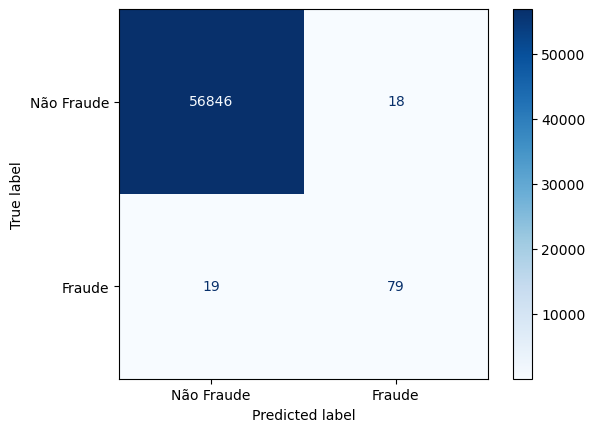

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#fazemos a previsão nos dados de TESTE (originais, desbalanceados)
y_pred = model.predict(X_test)

#relatório de classificação
print("\n--- Relatório de Classificação (Dados de Teste) ---")
#Usamos target_names para facilitar a leitura
print(classification_report(y_test, y_pred, target_names=['Não Fraude (0)', 'Fraude (1)']))

#matriz de confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

#plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig(f"models/Random-Forest/matrix-cofusao-Random-Forest-smote-2.png")
plt.show()

##### Usando ROS (RandomOverSampler)

In [73]:
model_ros = RandomForestClassifier(random_state=42, n_jobs=-1)
print("\nIniciando o treinamento do modelo RandomForest (com dados ROS)...")
model_ros.fit(X_train_ros, y_train_ros)
print("Treinamento concluído!")
print("\nModelo 'model_ros' treinado e pronto para fazer previsões.")


Iniciando o treinamento do modelo RandomForest (com dados ROS)...
Treinamento concluído!

Modelo 'model_ros' treinado e pronto para fazer previsões.


Avaliando o modelo 'model_ros' nos dados de TESTE...

--- Relatório de Classificação (RandomOversampler) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      1.00      1.00     56864
    Fraude (1)       0.94      0.78      0.85        98

      accuracy                           1.00     56962
     macro avg       0.97      0.89      0.92     56962
  weighted avg       1.00      1.00      1.00     56962


--- Matriz de Confusão (RandomOversampler) ---


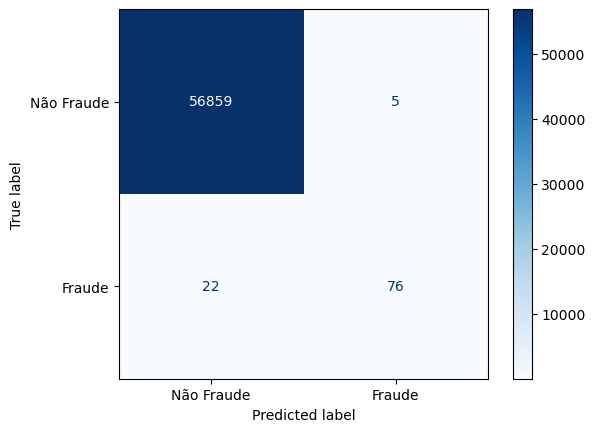

In [74]:
print("Avaliando o modelo 'model_ros' nos dados de TESTE...")

#fazer previsões nos dados de TESTE
y_pred_ros = model_ros.predict(X_test)

#mostrar relatório de classificação
print("\n--- Relatório de Classificação (RandomOversampler) ---")
print(classification_report(y_test, y_pred_ros, target_names=['Não Fraude (0)', 'Fraude (1)']))

#mostrar matriz de confusão
print("\n--- Matriz de Confusão (RandomOversampler) ---")
cm_ros = confusion_matrix(y_test, y_pred_ros)

#plotar a matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ros, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig(f"models/Random-Forest/matrix-cofusao-Random-Forest-random-oversampling.png")
plt.show()

#### Undersampling (Random)

In [75]:

print(f"Formato original de X_train: {X_train.shape}")
print(f"Distribuição original de y_train:\n{y_train.value_counts()}")

rus = RandomUnderSampler(random_state=42)
#aplicar o undersampling APENAS no conjunto de treino
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("\n--- Após RandomUnderSampler ---")
print(f"Novo formato de X_train_rus: {X_train_rus.shape}")
print(f"Nova distribuição de y_train_rus:\n{pd.Series(y_train_rus).value_counts()}")

Formato original de X_train: (227845, 30)
Distribuição original de y_train:
Class
0    227451
1       394
Name: count, dtype: int64

--- Após RandomUnderSampler ---
Novo formato de X_train_rus: (788, 30)
Nova distribuição de y_train_rus:
Class
0    394
1    394
Name: count, dtype: int64


#### Treinando Modelo

In [76]:
model_rus = RandomForestClassifier(random_state=42, n_jobs=-1)
print("\nIniciando treinamento com dados de Undersampling (RUS)...")
model_rus.fit(X_train_rus, y_train_rus)
print("Treinamento concluído.")


Iniciando treinamento com dados de Undersampling (RUS)...
Treinamento concluído.



Avaliando o modelo 'model_rus' nos dados de TESTE (originais)...

--- Relatório de Classificação (RandomUnderSampler) ---
                precision    recall  f1-score   support

Não Fraude (0)       1.00      0.96      0.98     56864
    Fraude (1)       0.04      0.91      0.08        98

      accuracy                           0.96     56962
     macro avg       0.52      0.94      0.53     56962
  weighted avg       1.00      0.96      0.98     56962



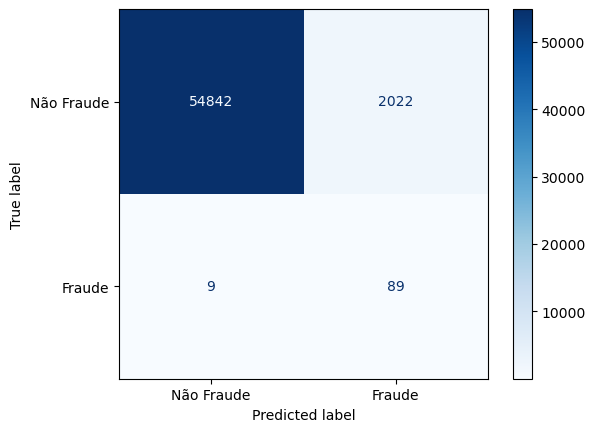

In [77]:


print("\nAvaliando o modelo 'model_rus' nos dados de TESTE (originais)...")

#fazer previsões nos dados de TESTE
y_pred_rus = model_rus.predict(X_test)

#mostrar Relatório de Classificação
print("\n--- Relatório de Classificação (RandomUnderSampler) ---")
print(classification_report(y_test, y_pred_rus, target_names=['Não Fraude (0)', 'Fraude (1)']))

#mostrar Matriz de Confusão
cm_rus = confusion_matrix(y_test, y_pred_rus)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rus, display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap=plt.cm.Blues)
plt.savefig(f"models/Random-Forest/matrix-cofusao-Random-Forest-random-undersampling.png")
plt.show()

#### Curva ROC


--- Avaliação dos Modelos (AUC-ROC) ---
AUC-ROC (SMOTE): 0.9688
AUC-ROC (RandomOversampler): 0.9577
AUC-ROC (RandomUnderSampler): 0.9782


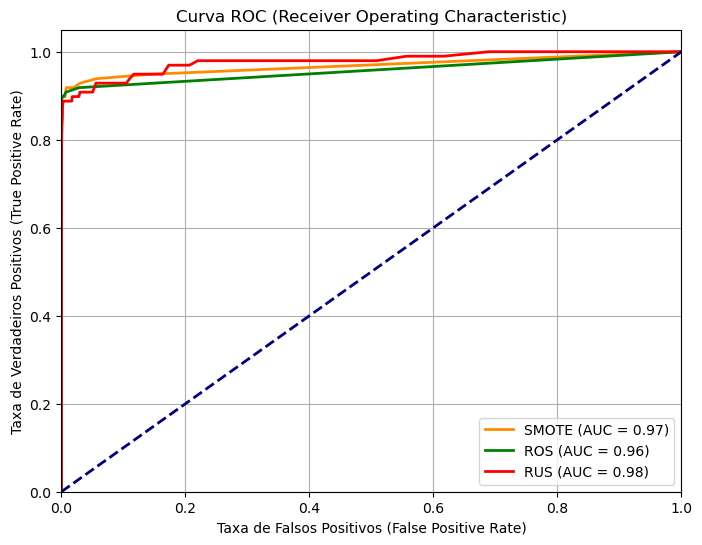

In [78]:
# Avaliação dos modelos usando AUC-ROC

print("\n--- Avaliação dos Modelos (AUC-ROC) ---")

# Modelo treinado com SMOTE
# Precisamos das probabilidades para calcular a curva ROC e a AUC
y_prob_smote = model.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_prob_smote)
auc_smote = auc(fpr_smote, tpr_smote)
print(f"AUC-ROC (SMOTE): {auc_smote:.4f}")

# Modelo treinado com ROS
y_prob_ros = model_ros.predict_proba(X_test)[:, 1]
fpr_ros, tpr_ros, thresholds_ros = roc_curve(y_test, y_prob_ros)
auc_ros = auc(fpr_ros, tpr_ros)
print(f"AUC-ROC (RandomOversampler): {auc_ros:.4f}")

# Modelo treinado com RUS
y_prob_rus = model_rus.predict_proba(X_test)[:, 1]
fpr_rus, tpr_rus, thresholds_rus = roc_curve(y_test, y_prob_rus)
auc_rus = auc(fpr_rus, tpr_rus)
print(f"AUC-ROC (RandomUnderSampler): {auc_rus:.4f}")

# Opcional: Plotar as curvas ROC para comparação
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label=f'SMOTE (AUC = {auc_smote:.2f})')
plt.plot(fpr_ros, tpr_ros, color='green', lw=2, label=f'ROS (AUC = {auc_ros:.2f})')
plt.plot(fpr_rus, tpr_rus, color='red', lw=2, label=f'RUS (AUC = {auc_rus:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (True Positive Rate)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.savefig(f"models/auc-roc-curve-notebook-2.png")
plt.grid(True)
plt.show()

#### Precision-Recall Curve


--- Avaliação dos Modelos (Precision-Recall Cruve) ---
Precision-Recall (SMOTE): 0.8695
Precision-Recall (RandomOversampler): 0.8692
Precision-Recall (RandomUnderSampler): 0.7598


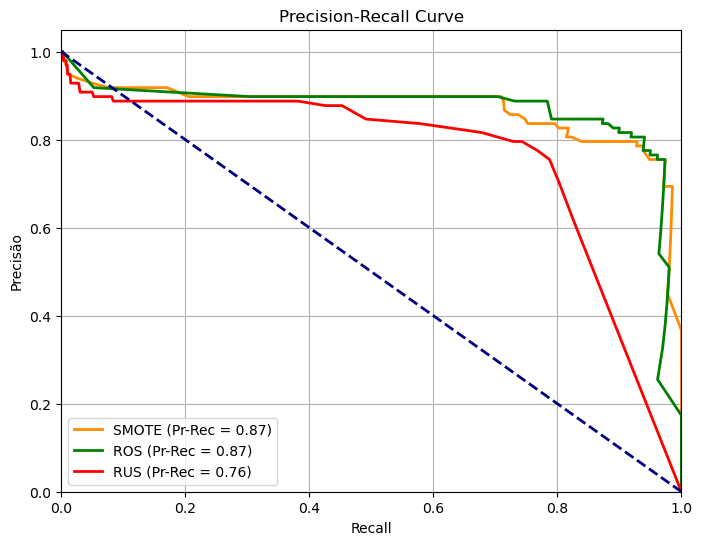

In [79]:
# Avaliação dos modelos usando Precision-Recall Curve
print("\n--- Avaliação dos Modelos (Precision-Recall Cruve) ---")

# Modelo treinado com SMOTE
# Precisamos das probabilidades para calcular a curva ROC e a AUC
y_prob_smote = model.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, thresholds_smote = precision_recall_curve(y_test, y_prob_smote)
pr_rec_smote = auc(tpr_smote, fpr_smote)
print(f"Precision-Recall (SMOTE): {pr_rec_smote:.4f}")

# Modelo treinado com ROS
y_prob_ros = model_ros.predict_proba(X_test)[:, 1]
fpr_ros, tpr_ros, thresholds_ros = precision_recall_curve(y_test, y_prob_ros)
pr_rec_ros = auc(tpr_ros, fpr_ros)
print(f"Precision-Recall (RandomOversampler): {pr_rec_ros:.4f}")

# Modelo treinado com RUS
y_prob_rus = model_rus.predict_proba(X_test)[:, 1]
fpr_rus, tpr_rus, thresholds_rus = precision_recall_curve(y_test, y_prob_rus)
pr_rec_rus = auc(tpr_rus, fpr_rus)
print(f"Precision-Recall (RandomUnderSampler): {pr_rec_rus:.4f}")

# Opcional: Plotar as curvas ROC para comparação
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label=f'SMOTE (Pr-Rec = {pr_rec_smote:.2f})')
plt.plot(fpr_ros, tpr_ros, color='green', lw=2, label=f'ROS (Pr-Rec = {pr_rec_ros:.2f})')
plt.plot(fpr_rus, tpr_rus, color='red', lw=2, label=f'RUS (Pr-Rec = {pr_rec_rus:.2f})')
plt.plot([1, 0], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig(f"models/pr-rec-curve-notebook-2.png")
plt.grid(True)
plt.show()

#### Salva os dados na planilha

In [80]:
save_sheet("SMOTE-2", y_test, y_pred, pr_rec_smote, auc_smote) #SMOTE
save_sheet("Random Oversampling", y_test, y_pred_ros, pr_rec_ros, auc_ros) #Random Oversampling
save_sheet("Random Undersampling", y_test, y_pred_rus, pr_rec_rus, auc_rus) #Random Undersampling

# Conclusao

-Random Oversampling (ROS): Aumentou significativamente o recall da classe minoritária (Fraude), mas pode ter gerado um modelo um pouco mais propenso a falsos positivos em comparação com o SMOTE (embora a precisão ainda seja alta, 0.94). A matriz de confusão do ROS mostra mais Verdadeiros Positivos (TP) e alguns Falsos Positivos (FP).

-SMOTE: Também melhorou o recall da classe minoritária e apresentou uma precisão ligeiramente menor (0.81) em comparação com o ROS, mas com um f1-score similar. A matriz de confusão do SMOTE mostra um bom equilíbrio entre TP e FP.

-Random UnderSampler (RUS): Reduziu drasticamente o tamanho do conjunto de treino. Embora tenha atingido um recall muito alto para a classe minoritária (0.91), a precisão para a classe minoritária foi muito baixa (0.04). Isso significa que o modelo treinado com RUS identificou a maioria das fraudes (alto recall), mas também gerou um número muito grande de falsos positivos (baixa precisão), tornando-o menos prático em um cenário real onde falsos alarmes são custosos. A matriz de confusão do RUS confirma um grande número de Falsos Positivos.

Comparando as três técnicas aplicadas:

O Random UnderSampler (RUS), embora tenha um alto recall, gerou um número excessivo de falsos positivos, tornando-o menos ideal para este caso.
Tanto o Random Oversampling (ROS) quanto o SMOTE foram eficazes em melhorar a capacidade do modelo de detectar fraudes (aumentando o recall) em comparação com um cenário sem balanceamento.
A escolha entre SMOTE e ROS dependeria dos requisitos específicos do problema:

Se minimizar Falsos Negativos (não detectar uma fraude real) for a prioridade máxima, mesmo que isso resulte em mais Falsos Positivos, o ROS pode ser ligeiramente preferível (maior recall em 0.81 vs 0.78).
Se houver uma necessidade de equilibrar a detecção de fraudes com a minimização de falsos alarmes, o SMOTE (com precisão de 0.81 e recall de 0.81) parece oferecer um bom compromisso neste caso específico.